### Model Interpretation for Binary MNIST Model using RISE

This notebook demonstrates how to apply RISE algorithms on pretrained binary MNIST model using a hand-written digit image and visualizes the attributions for each pixel/super-pixel by displaying them on the image.<br>

RISE is short for Randomized Input Sampling for Explanation of Black-box Models. It estimates importance empirically by probing the model with randomly masked versions of the input image and obtaining the corresponding outputs.<br>

More details about this method can be found in the paper https://arxiv.org/abs/1806.07421.<br>

In [1]:
import warnings
warnings.filterwarnings('ignore') # disable warnings relateds to versions of tf
import dianna
import onnxruntime
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.special import softmax
from dianna import visualization

#### 1 - Loading the model and the dataset
Loads pretrained binary MNIST model and the image to be explained.

Load saved binary MNIST data.

In [2]:
# load dataset
data = np.load('./data/binary-mnist.npz')
# load testing data and the related labels
X_test = data['X_test'].astype(np.float32).reshape([-1, 1, 28, 28])
y_test = data['y_test']
# define axis labels for the testing data
axis_labels = {0: 'batch', 1: 'channels'}

Load the pretrained binary MNIST model and define a model runner.

In [3]:
def run_model(data):
    fname = './models/mnist_model.onnx'
    # get ONNX predictions
    sess = onnxruntime.InferenceSession(fname)
    input_name = sess.get_inputs()[0].name
    output_name = sess.get_outputs()[0].name
    
    onnx_input = {input_name: data}
    pred_onnx = sess.run([output_name], onnx_input)
    
    return softmax(pred_onnx[0], axis=1)

pred_onnx = run_model(X_test)

Print class and image of a single instance in the test data for preview.

The predicted class is: digit 0


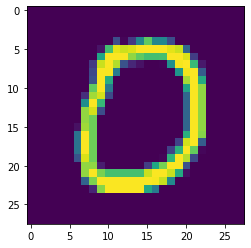

In [14]:
# class name
class_name = ['digit 0', 'digit 1']
# instance index
i_instance = 3
# predicted class
pred_class = class_name[np.argmax(pred_onnx[i_instance])]
print("The predicted class is:", pred_class)
plt.imshow(X_test[i_instance][0])  # 0 for channel

#### 2 - Compute attributions and visualize the saliency
Compute attributions using RISE and visualize the saliency on the image. 

RISE masks random portions of the input image and passes this image through the model — the mask that damages accuracy the most is the most “important” portion.<br>
To call the explainer and generate saliency map, the user need to specified the number of masks being randomly generated (`n_masks`), the resolution of features in masks (`feature_res`) and the fraction of image to keep in each mask (`p_keep`).

In [12]:
heatmaps = dianna.explain_image(run_model, X_test[[i_instance]], method="RISE",
                                labels=[i for i in range(2)],
                                n_masks=5000, feature_res=8, p_keep=.1,
                                axes_labels=('batch','channels','height','width'))

Explaining: 100%|██████████| 50/50 [00:00<00:00, 125.30it/s]


Visualize the saliency map on the image for the predicted class.

Explanation for `digit 0`


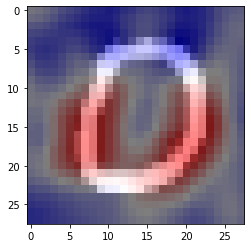

In [15]:
print(f'Explanation for `{pred_class}`')
visualization.plot_image(heatmaps[0], X_test[i_instance][0], data_cmap='gray', heatmap_cmap='bwr')

#### 3 - Conclusions
These saliency maps are generated by passing multiple randomly masked input to the black-box model and averaging their importance scores. The idea behind this is that whenever a mask preserves important parts of the image it gets higher score. <br>

The example here shows that the RISE method evaluates the importance of each pixel/super pixel to the classification and the results are reasonable based on human visual preception of the testing image.